# SUPERVISED METHODS

In this notebook I wil practice different supervised methods (like naive-bayes, knn...) and apply them to a practical case.

In [154]:
import numpy as np 
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils import check_random_state
from sklearn import tree

# Visualizar árboles
from IPython.display import Image
import pydotplus
from six import StringIO

# UMAP para la reducción de dimensionalidad
import umap

# Visualización
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

In [155]:
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation].astype(int)
X = X.reshape((X.shape[0], -1))

KeyboardInterrupt: 

In [ ]:
fig, axis = plt.subplots(1, 10, figsize=(12, 6))
for i, ax in zip(range(10), axis):
    ax.imshow(X[y == i][0].reshape(28, 28), cmap='gray_r')
    ax.set_title(str(i))
    ax.axis('off')
plt.tight_layout()

In [ ]:
all_data = pd.DataFrame(X)
all_data['y'] = y

sample_data = all_data.sample(frac = 0.1, random_state=24)
X = sample_data.drop(columns=['y'])
y = sample_data['y']

print(all_data.shape)
print(sample_data.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(sample_data, y, test_size = 0.2, random_state = 24)

In [ ]:
model = umap.UMAP(n_components=2, random_state=42)
model.fit(X_train)
X_train_projection = model.transform(X_train)
X_test_projection = model.transform(X_test)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(10):
    ax.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], s=3, label=str(i))
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# vamos a crear la meshgrid con los valores mínimos y máximos de los ejes x e y
x_min, x_max = X_test_projection[:, 0].min() - 1, X_test_projection[:, 0].max() + 1
y_min, y_max = X_test_projection[:, 1].min() - 1, X_test_projection[:, 1].max() + 1
    
# definimos la función que visualizará la frontera de decisión
def plot_decision_boundaries(model, X_test_projection, y_test):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    # precedimos con el clasificador con los valores de la meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # definimos los colores (uno para cada clase)
    cmap_light = ListedColormap(['gainsboro','lightgreen','peachpuff','lightcyan', 'pink',
                                 'lightyellow','lavender','lightcoral', 'lightskyblue', 'aquamarine'])
    cmap_bold = ['grey','g','sandybrown','c','palevioletred', 
                 'y','mediumpurple','firebrick', 'dodgerblue', 'mediumaquamarine']
    
    # dibujamos las fronteras
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(20,10))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # dibujamos los puntos
    for i in range(10):
        plt.scatter(X_test_projection[y_test == i,0], X_test_projection[y_test == i,1], 
                    s=3, label=str(i), c=cmap_bold[i])
    plt.legend()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

### Naive bayes

In [ ]:
# el modelo
gauss = GaussianNB()
# entrenamos el modelo
gauss.fit(X_train_projection, y_train)
# hacemos una predicción
y_pred = gauss.predict(X_test_projection)

In [ ]:
#representamos gráficamente la frontera de decisión
plot_decision_boundaries(gauss, X_test_projection, y_test)
plt.show()

In [ ]:
print('Accuracy del clasificador GaussianNB training set: {:.2f}'.format(gauss.score(X_train_projection, y_train)))
print('Accuracy del clasificador GaussianNB test set: {:.2f}'.format(gauss.score(X_test_projection, y_test)))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
      
print("Classification report:")
print(classification_report(y_test, y_pred))

En la frontera de decisión que hemos obtenido vemos 10 partes diferenciadas, una por cada número. Aunque por lo general todas están bien delimitadas, la porción para el número 9 (el color verde/azul de la parte inferior derecha) tiene una zona más desforme que el resto. Por lo general, vemos que los números están bien ordenados en su zona, pero esta parte inferior derecha podemos apreciar que hay muchos números que no están bien clasificados. Hemos obtenido una predicción con un acierto del .86. Es un buen porcentaje, pero se puede mejorar.

### KNN

In [ ]:
# el modelo, con dos vecinos
knn = KNeighborsClassifier(2)
# entrenamos el modelo
knn.fit(X_train_projection, y_train)
# la preddicón
y_pred = knn.predict(X_test_projection)

In [ ]:
plot_decision_boundaries(knn, X_test_projection, y_test)
plt.show()

In [ ]:
print('Accuracy del clasificador KNN en training set: {:.2f}'.format(knn.score(X_train_projection, y_train)))
print('Accuracy del clasificador KNN test set: {:.2f}'.format(knn.score(X_test_projection, y_test)))

In [ ]:
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
      
print("Classification report:")
print(classification_report(y_test, y_pred))

In [ ]:
# definimos los parámetros a valorar
grid_params = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10]
}
# definimos la GridSearch
gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)
# el resultado
gs_results = gs.fit(X_train_projection, y_train)

In [ ]:
#gs_results.best_estimator_
print("El mejor párametro es:",gs_results.best_params_)
#gs_results.cv_results_

In [ ]:
pvt = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
    values='rank_test_score',  columns=['param_n_neighbors'])
ax = sns.heatmap(pvt)
plt.show(ax)

In [ ]:
# repetimos con 7 vecinos
knn = KNeighborsClassifier(7)
knn.fit(X_train_projection, y_train)
y_pred = knn.predict(X_test_projection)

In [ ]:
plot_decision_boundaries(knn, X_test_projection, y_test)
plt.show()

In [ ]:
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train_projection, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test_projection, y_test)))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
      
print("Classification report:")
print(classification_report(y_test, y_pred))

A la hora de buscar el mejor número de vecinos, hemos obtenido 9 como resultado. Siendo 2, los vecinos que habíamos usado inicialmente, el parámetro que peor funcionaría de los 10 que hemos propuesto. La visualización gráficamente ha mejorado ya que 9 era una mejor opción que 2. Las fronteras de decisión siguen siendo caóticas, pero también han mejorado. Las predicciones del test han mejorado en .03 puntos, pasando de .87 a .90, lo cual es una buena mejora.

### SVM

In [ ]:
# los parametros que vamos a usar
tuned_parameters = [{'gamma': [0.001, 0.01, 0.1, 10],
                     'C': [0.01, 0.1, 1, 10, 50, 100, 200]}]
# definimos la GridSearch
gs = GridSearchCV(
    SVC(),
    tuned_parameters,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)
# los resultados
gs_results = gs.fit(X_train_projection, y_train)

In [ ]:
#gs_results.best_estimator_
print("El mejor párametro es:",gs_results.best_params_)
#gs_results.cv_results_

In [ ]:
pvt = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
    values='rank_test_score', index= 'param_gamma', columns=['param_C'])
ax = sns.heatmap(pvt)
plt.show(ax)

In [ ]:
svc = SVC(C=1, gamma=10)
svc.fit(X_train_projection, y_train)
y_pred = svc.predict(X_test_projection)

In [ ]:
plot_decision_boundaries(svc, X_test_projection, y_test)
plt.show()

In [ ]:
print('Accuracy of SVC classifier on training set: {:.2f}'.format(svc.score(X_train_projection, y_train)))
print('Accuracy of SVC classifier on test set: {:.2f}'.format(svc.score(X_test_projection, y_test)))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
      
print("Classification report:")
print(classification_report(y_test, y_pred))

### Decision Tress

In [ ]:
tuned_parameters = [{'max_depth': [4,5,6,7,8,9,10],
                     'min_samples_split': [2,10,20,50,100]}]

gs = GridSearchCV(
    DecisionTreeClassifier(),
    tuned_parameters,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

gs_results = gs.fit(X_train_projection, y_train)

In [ ]:
#gs_results.best_estimator_
print("El mejor párametro es:",gs_results.best_params_)
#gs_results.cv_results_

In [ ]:
pvt = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
    values='rank_test_score', index='param_max_depth', columns=['param_min_samples_split'])
ax = sns.heatmap(pvt)
plt.show(ax)

In [ ]:
tree = DecisionTreeClassifier(max_depth = 8, min_samples_split = 50)
tree.fit(X_train_projection,y_train)
y_pred = tree.predict(X_test_projection)

In [ ]:
plot_decision_boundaries(tree, X_test_projection, y_test)
plt.show()

In [ ]:
print('Accuracy del Tree Classifier en training set: {:.2f}'.format(tree.score(X_train_projection, y_train)))
print('Accuracy del Tree Classifier en test set: {:.2f}'.format(tree.score(X_test_projection, y_test)))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
      
print("Classification report:")
print(classification_report(y_test, y_pred))

### Decision Tree Improved

In [ ]:
tuned_parameters = [{'max_depth': [8,9,10,11,12],
                     'n_estimators': [50,100,200]}]

gs = GridSearchCV(
    RandomForestClassifier(),
    tuned_parameters,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

gs_results = gs.fit(X_train_projection, y_train)

In [ ]:
#gs_results.best_estimator_
print("El mejor párametro es:",gs_results.best_params_)
#gs_results.cv_results_

In [ ]:
pvt = pd.pivot_table(pd.DataFrame(gs_results.cv_results_),
    values='rank_test_score', index='param_max_depth', columns=['param_n_estimators'])
ax = sns.heatmap(pvt)
plt.show(ax)

In [ ]:
forest = RandomForestClassifier(max_depth = 8, n_estimators = 100)
forest.fit(X_train_projection,y_train)
y_pred = forest.predict(X_test_projection)

In [ ]:
plot_decision_boundaries(forest, X_test_projection, y_test)
plt.show()

In [ ]:
print('Accuracy del Tree Classifier en training set: {:.2f}'.format(forest.score(X_train_projection, y_train)))
print('Accuracy del Tree Classifier en test set: {:.2f}'.format(forest.score(X_test_projection, y_test)))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
      
print("Classification report:")
print(classification_report(y_test, y_pred))

## Practical Case

In [ ]:
hipotecas = pd.read_csv("hipotecas.csv")
hipotecas.head(10)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,hipoteca
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


### Descriptive analysis

In [ ]:
print(hipotecas.groupby('hipoteca').size())

hipoteca
0    135
1     67
dtype: int64


In [ ]:
# hacemos un diagrama de barras 
labels = [hipotecas["hipoteca"].value_counts()[1], 
          hipotecas["hipoteca"].value_counts()[0]]
values = np.arange(len(labels))
# creamos el plot
plt.bar(values, labels, color=("greenyellow","turquoise"), edgecolor="grey")
# diseñamos los nombres para el eje x
plt.xticks(values, ('Sí ('+str(hipotecas["hipoteca"].value_counts()[1])+')',
                   'No ('+str(hipotecas["hipoteca"].value_counts()[0])+')'))
plt.xlabel("¿Tiene hipoteca?", labelpad=14)
plt.ylabel("Total", labelpad=14,)

Text(0, 0.5, 'Total')

In [ ]:
hipotecas.iloc[:,[0,1,2,3,4,5,7]].describe().T

,count,mean,std,min,25%,50%,75%,max
ingresos,202.0,4958.995050,1682.862556,2008.0,3513.75,4947.5,6374.50,7984.0
gastos_comunes,202.0,971.584158,272.106351,384.0,766.75,968.0,1165.25,1585.0
pago_coche,202.0,211.742574,124.940754,0.0,99.00,208.5,318.75,448.0
gastos_otros,202.0,515.425743,168.103075,201.0,383.25,522.5,656.75,828.0
ahorros,202.0,38749.668317,17365.231870,10319.0,24964.25,38523.0,52150.75,69934.0
vivienda,202.0,373349.638614,136371.525622,176553.0,274810.00,340783.5,444482.00,669540.0
hijos,202.0,1.232673,1.367833,0.0,0.00,1.0,2.00,4.0


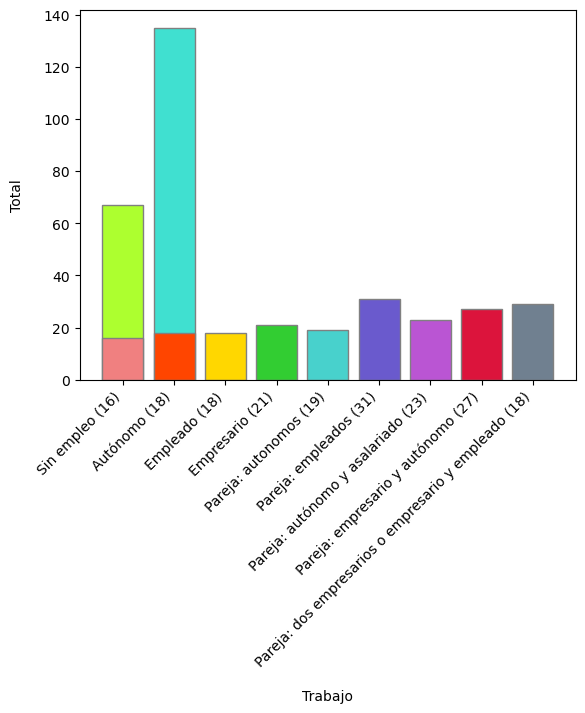

In [ ]:
labels = [hipotecas["trabajo"].value_counts()[0], 
          hipotecas["trabajo"].value_counts()[1],
          hipotecas["trabajo"].value_counts()[2],
          hipotecas["trabajo"].value_counts()[3],
          hipotecas["trabajo"].value_counts()[4],
          hipotecas["trabajo"].value_counts()[5],
          hipotecas["trabajo"].value_counts()[6],
          hipotecas["trabajo"].value_counts()[7],
          hipotecas["trabajo"].value_counts()[8]]
values = np.arange(len(labels))
# creamos el plot
plt.bar(values, labels, 
        color=("lightcoral","orangered","gold","limegreen",
               "mediumturquoise","slateblue","mediumorchid","crimson","slategrey"), 
        edgecolor="grey")
# diseñamos los nombres para el eje x
plt.xticks(values, ('Sin empleo ('+str(hipotecas["trabajo"].value_counts()[0])+')',
                   'Autónomo ('+str(hipotecas["trabajo"].value_counts()[1])+')',
                   'Empleado ('+str(hipotecas["trabajo"].value_counts()[2])+')',
                   'Empresario ('+str(hipotecas["trabajo"].value_counts()[3])+')',
                   'Pareja: autonomos ('+str(hipotecas["trabajo"].value_counts()[4])+')',
                   'Pareja: empleados ('+str(hipotecas["trabajo"].value_counts()[5])+')',
                   'Pareja: autónomo y asalariado ('+str(hipotecas["trabajo"].value_counts()[6])+')',
                   'Pareja: empresario y autónomo ('+str(hipotecas["trabajo"].value_counts()[7])+')',
                   'Pareja: dos empresarios o empresario y empleado ('+str(hipotecas["trabajo"].value_counts()[2])+')'),
           rotation=45, ha='right')
plt.xlabel("Trabajo", labelpad=14)
plt.ylabel("Total", labelpad=14)
plt.show()


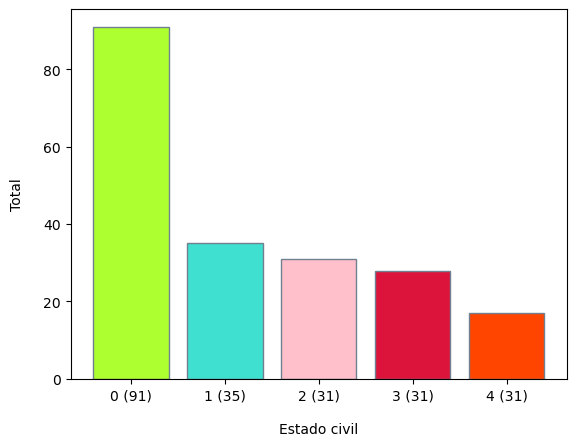

In [ ]:
labels = [hipotecas["hijos"].value_counts()[0], 
          hipotecas["hijos"].value_counts()[1],
          hipotecas["hijos"].value_counts()[2],
          hipotecas["hijos"].value_counts()[3],
          hipotecas["hijos"].value_counts()[4]]
values = np.arange(len(labels))
# creamos el plot
plt.bar(values, labels, color=("greenyellow","turquoise","pink","crimson","orangered"),edgecolor="slategrey")
# diseñamos los nombres para el eje x
plt.xticks(values, ('0 ('+str(hipotecas["hijos"].value_counts()[0])+')',
                   '1 ('+str(hipotecas["hijos"].value_counts()[1])+')',
                   '2 ('+str(hipotecas["hijos"].value_counts()[2])+')',
                   '3 ('+str(hipotecas["hijos"].value_counts()[2])+')',
                   '4 ('+str(hipotecas["hijos"].value_counts()[2])+')'))
plt.xlabel("Estado civil", labelpad=14)
plt.ylabel("Total", labelpad=14)
plt.show()

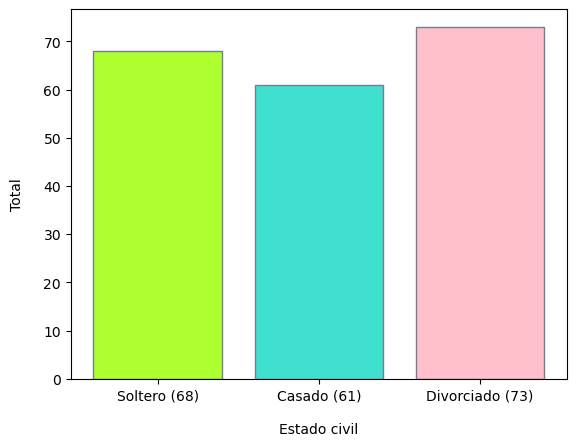

In [ ]:
labels = [hipotecas["estado_civil"].value_counts()[0], 
          hipotecas["estado_civil"].value_counts()[1],
          hipotecas["estado_civil"].value_counts()[2]]
values = np.arange(len(labels))
# creamos el plot
plt.bar(values, labels, color=("greenyellow","turquoise","pink"),edgecolor="slategrey")
# diseñamos los nombres para el eje x
plt.xticks(values, ('Soltero ('+str(hipotecas["estado_civil"].value_counts()[0])+')',
                   'Casado ('+str(hipotecas["estado_civil"].value_counts()[1])+')',
                   'Divorciado ('+str(hipotecas["estado_civil"].value_counts()[2])+')'))
plt.xlabel("Estado civil", labelpad=14)
plt.ylabel("Total", labelpad=14)
plt.show()

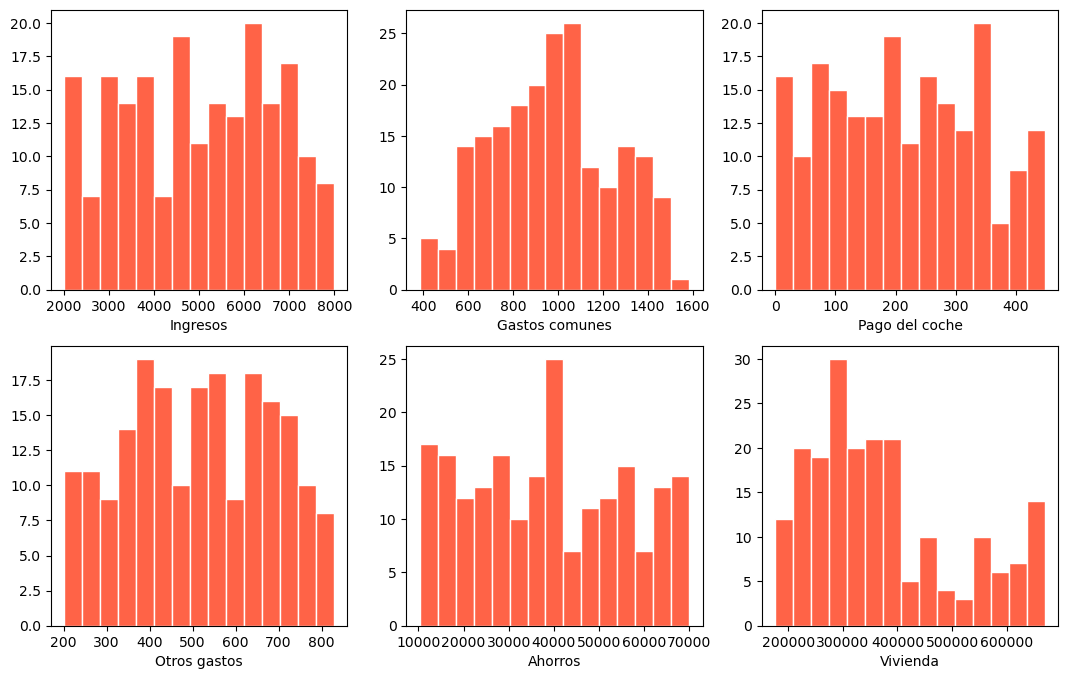

In [ ]:
f = plt.figure(figsize=(13, 8))
# ingresos
f.add_subplot(231)
plt.hist(hipotecas['ingresos'], color = "tomato", edgecolor='white', bins = 15)
plt.xlabel("Ingresos")

# gastos comunes
f.add_subplot(232)
plt.hist(hipotecas['gastos_comunes'], color = "tomato", edgecolor='white', bins = 15)
plt.xlabel("Gastos comunes")

# pagos del coche
f.add_subplot(233)
plt.hist(hipotecas['pago_coche'], color = "tomato", edgecolor='white', bins = 15)
plt.xlabel("Pago del coche")

# otros gastos
f.add_subplot(234)
plt.hist(hipotecas['gastos_otros'], color = "tomato", edgecolor='white', bins = 15)
plt.xlabel("Otros gastos")

# ahorros
f.add_subplot(235)
plt.hist(hipotecas['ahorros'], color = "tomato", edgecolor='white', bins = 15)
plt.xlabel("Ahorros")

# vivienda
f.add_subplot(236)
plt.hist(hipotecas['vivienda'], color = "tomato", edgecolor='white', bins = 15)
plt.xlabel("Vivienda")

plt.show()

### Data processing

In [ ]:
hipotecas.isnull().sum()

ingresos          0
gastos_comunes    0
pago_coche        0
gastos_otros      0
ahorros           0
vivienda          0
estado_civil      0
hijos             0
trabajo           0
hipoteca          0
dtype: int64

In [ ]:
hipotecas['gastos'] = (hipotecas['pago_coche'] + hipotecas['gastos_comunes'] + hipotecas['gastos_otros'])
hipotecas.head()

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,hipoteca,gastos
0,6000,1000,0,600,50000,400000,0,2,2,1,1600
1,6745,944,123,429,43240,636897,1,3,6,0,1496
2,6455,1033,98,795,57463,321779,2,1,8,1,1926
3,7098,1278,15,254,54506,660933,0,0,3,0,1547
4,6167,863,223,520,41512,348932,0,0,3,1,1606


In [ ]:
hipotecas['financiar'] = hipotecas['vivienda'] - hipotecas['ahorros']
hipotecas.head()

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,hipoteca,gastos,financiar
0,6000,1000,0,600,50000,400000,0,2,2,1,1600,350000
1,6745,944,123,429,43240,636897,1,3,6,0,1496,593657
2,6455,1033,98,795,57463,321779,2,1,8,1,1926,264316
3,7098,1278,15,254,54506,660933,0,0,3,0,1547,606427
4,6167,863,223,520,41512,348932,0,0,3,1,1606,307420


In [ ]:
df = hipotecas.drop(['gastos_comunes','gastos_otros','pago_coche','ahorros','vivienda'], axis = 1)
df.head()

,ingresos,estado_civil,hijos,trabajo,hipoteca,gastos,financiar
0,6000,0,2,2,1,1600,350000
1,6745,1,3,6,0,1496,593657
2,6455,2,1,8,1,1926,264316
3,7098,0,0,3,0,1547,606427
4,6167,0,0,3,1,1606,307420


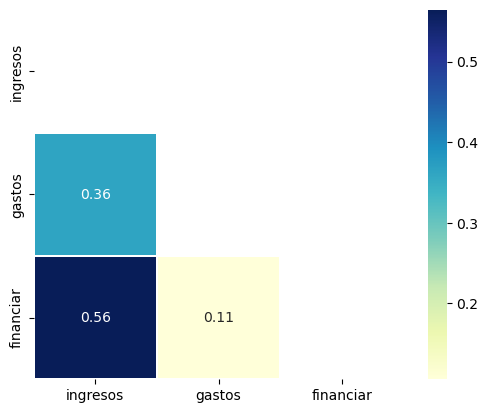

In [ ]:
# creamos un nuevo data frame donde solo tengamos las variables que estamos analizando
df_analysis = df[["ingresos","gastos","financiar"]]
# creamos la matriz de correlación:
corr = df_analysis.corr().round(4)
# creamos una más cara para mostrar solo la mitad de la gráfica de correlación
mask = np.triu(np.ones_like(corr, dtype=bool))
# mostramos gráicamente la matriz
sns.heatmap(corr, mask=mask, annot = True, cmap = 'YlGnBu', linewidths = 0.2, square = True)
plt.show()

C:\Users\iredi\AppData\Local\Temp\ipykernel_1680\2639121793.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Soltero","Casado","Divorciado"])


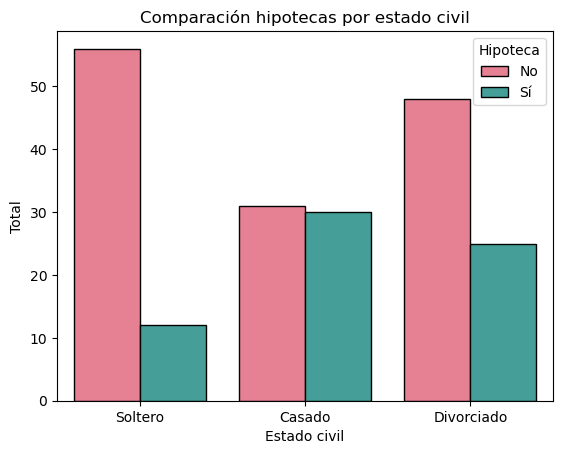

In [ ]:
x = df.groupby(['hipoteca','estado_civil']).size().to_frame('occurences').reset_index()
sns.set_palette("Set2", 1)
ax = sns.barplot(x='estado_civil', y='occurences', hue='hipoteca', edgecolor = "black", data=x)
ax.set(xlabel='Estado civil', ylabel='Total', title='Comparación hipotecas por estado civil')
ax.set_xticklabels(["Soltero","Casado","Divorciado"])
h, l = ax.get_legend_handles_labels()
labels=["No","Sí"]
ax.legend(h, labels, title="Hipoteca")
plt.show()

C:\Users\iredi\AppData\Local\Temp\ipykernel_1680\1725370804.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Sin empleo","Autónomo","Empleado","Empresario","Pareja: autónomos",


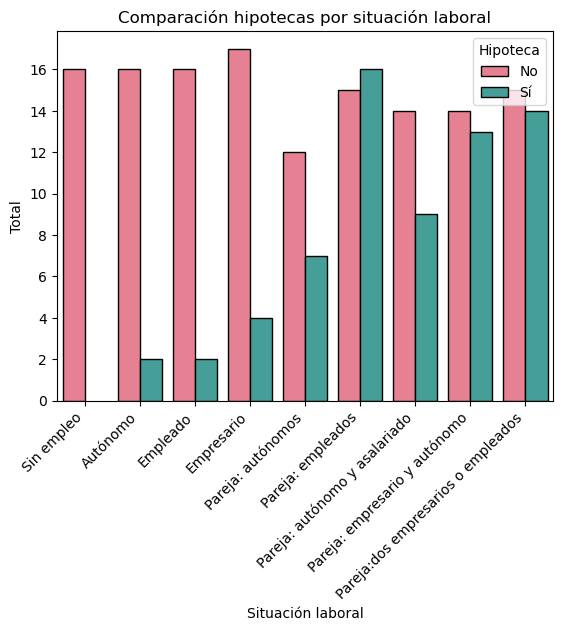

In [ ]:
x = df.groupby(['hipoteca','trabajo']).size().to_frame('occurences').reset_index()
sns.set_palette("Set2", 1)
ax=sns.barplot(x='trabajo', y='occurences', hue='hipoteca', edgecolor = "black", data=x)
ax.set(xlabel='Situación laboral', ylabel='Total', title='Comparación hipotecas por situación laboral')
ax.set_xticklabels(["Sin empleo","Autónomo","Empleado","Empresario","Pareja: autónomos",
                    "Pareja: empleados","Pareja: autónomo y asalariado","Pareja: empresario y autónomo",
                    "Pareja:dos empresarios o empleados"],
                   rotation=45, ha='right')
h, l = ax.get_legend_handles_labels()
labels=["No","Sí"]
ax.legend(h, labels, title="Hipoteca")
plt.show()

C:\Users\iredi\AppData\Local\Temp\ipykernel_1680\2077759094.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0","1","2","3","4"])


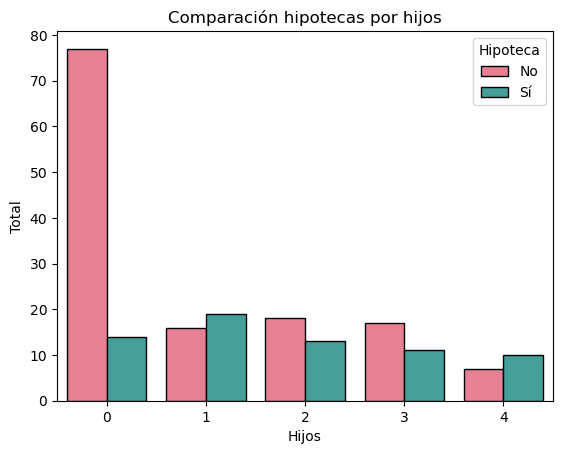

In [ ]:
x = df.groupby(['hipoteca','hijos']).size().to_frame('occurences').reset_index()
sns.set_palette("Set2", 1)
ax=sns.barplot(x='hijos', y='occurences', hue='hipoteca', edgecolor = "black", data=x)
ax.set(xlabel='Hijos', ylabel='Total', title='Comparación hipotecas por hijos')
ax.set_xticklabels(["0","1","2","3","4"])
h, l = ax.get_legend_handles_labels()
labels=["No","Sí"]
ax.legend(h, labels, title="Hipoteca")
plt.show()

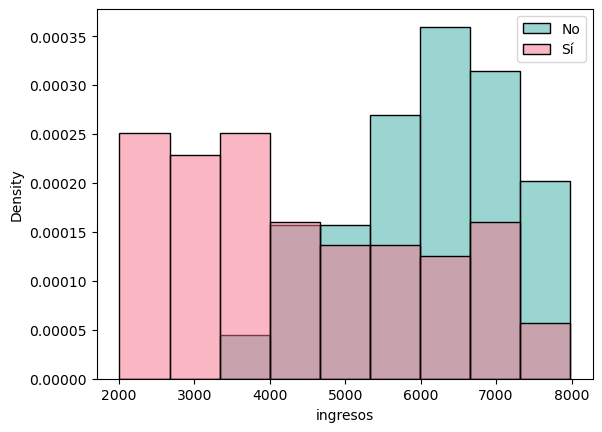

In [ ]:
x = df.groupby(['hipoteca','ingresos']).size().to_frame('occurences').reset_index()
fig = sns.histplot(
    x, x="ingresos", hue="hipoteca", 
    stat="density", common_norm=False, alpha=0.5
)
fig.legend(labels=['No','Sí'])
plt.show()

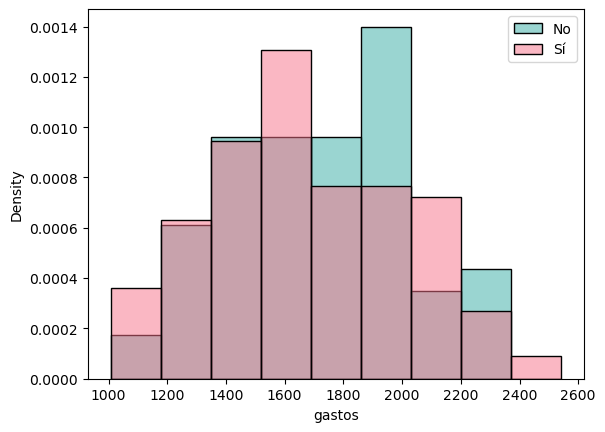

In [ ]:
x = df.groupby(['hipoteca','gastos']).size().to_frame('occurences').reset_index()
fig = sns.histplot(
    x, x="gastos", hue="hipoteca", 
    stat="density", common_norm=False, alpha=0.5
)
fig.legend(labels=['No','Sí'])
plt.show()

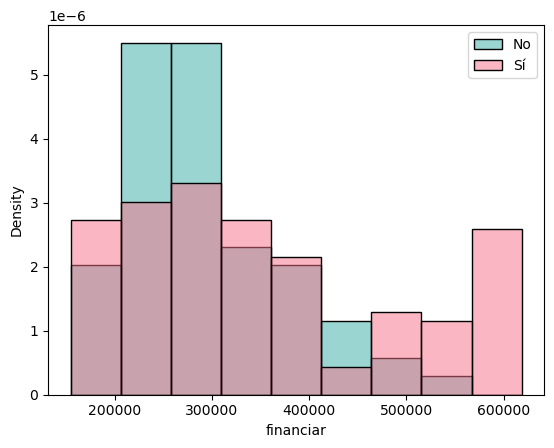

In [ ]:
x = df.groupby(['hipoteca','financiar']).size().to_frame('occurences').reset_index()
fig = sns.histplot(
    x, x="financiar", hue="hipoteca", 
    stat="density", common_norm=False, alpha=0.5
)
fig.legend(labels=['No','Sí'])
plt.show()

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df[['estado_civil']]).toarray())
df = df.join(enc_df)

In [ ]:
df.rename(columns={0: "soltero", 1: "casado", 2: "divorciado"}, inplace=True)
df.head()

,ingresos,estado_civil,hijos,trabajo,hipoteca,gastos,financiar,soltero,casado,divorciado
0,6000,0,2,2,1,1600,350000,1.0,0.0,0.0
1,6745,1,3,6,0,1496,593657,0.0,1.0,0.0
2,6455,2,1,8,1,1926,264316,0.0,0.0,1.0
3,7098,0,0,3,0,1547,606427,1.0,0.0,0.0
4,6167,0,0,3,1,1606,307420,1.0,0.0,0.0


In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(df[['trabajo']]).toarray())
df = df.join(enc_df)

In [ ]:
df.rename(columns={0: "sin empleo", 1: "autónomo", 2: "empleado", 3: "empresario",
                  4: "pareja: autónomos", 5: "pareja: empleados", 6: "pareja: autónomo y asalariado",
                  7: "pareja: empresario y autónomo", 8: "pareja: dos empresarios / empresario y empleado"}, inplace=True)
df

,ingresos,estado_civil,hijos,trabajo,hipoteca,gastos,financiar,soltero,casado,divorciado,sin empleo,autónomo,empleado,empresario,pareja: autónomos,pareja: empleados,pareja: autónomo y asalariado,pareja: empresario y autónomo,pareja: dos empresarios / empresario y empleado
0,6000,0,2,2,1,1600,350000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6745,1,3,6,0,1496,593657,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,6455,2,1,8,1,1926,264316,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7098,0,0,3,0,1547,606427,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,6167,0,0,3,1,1606,307420,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,3831,0,0,2,0,1530,352397,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
198,3961,2,3,8,0,1775,258541,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
199,3184,1,3,8,0,1915,352460,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
200,3334,1,2,5,0,1888,356907,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
df = df.drop(['estado_civil','trabajo'], axis = 1)
df.head(10)

,ingresos,hijos,hipoteca,gastos,financiar,soltero,casado,divorciado,sin empleo,autónomo,empleado,empresario,pareja: autónomos,pareja: empleados,pareja: autónomo y asalariado,pareja: empresario y autónomo,pareja: dos empresarios / empresario y empleado
0,6000,2,1,1600,350000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6745,3,0,1496,593657,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,6455,1,1,1926,264316,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7098,0,0,1547,606427,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,6167,0,1,1606,307420,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,5692,4,1,1247,309988,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,6830,1,1,1952,383051,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,6470,0,0,1856,548852,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,6251,0,1,2030,240507,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,6987,1,1,1755,283487,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df=df[["ingresos","gastos","financiar","hijos","soltero","casado","divorciado","sin empleo","autónomo","empleado",
     "pareja: autónomos","pareja: empleados","pareja: autónomo y asalariado","pareja: empresario y autónomo",
      "pareja: dos empresarios / empresario y empleado","hipoteca"]]
df.head(1)

,ingresos,gastos,financiar,hijos,soltero,casado,divorciado,sin empleo,autónomo,empleado,pareja: autónomos,pareja: empleados,pareja: autónomo y asalariado,pareja: empresario y autónomo,pareja: dos empresarios / empresario y empleado,hipoteca
0,6000,1600,350000,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


### Training the model

In [ ]:
x = df.iloc[:,:15]
y = df['hipoteca']
y = y.values

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 24)

In [ ]:
clt = DecisionTreeClassifier(max_depth = 5)
clt.fit(X_train, y_train)
y_pred = clt.predict(X_test)

text_representation = tree.export_text(clt)
print(text_representation)

|--- feature_0 <= 4506.00
|   |--- feature_13 <= 0.50
|   |   |--- class: 0
|   |--- feature_13 >  0.50
|   |   |--- feature_0 <= 3159.50
|   |   |   |--- class: 0
|   |   |--- feature_0 >  3159.50
|   |   |   |--- feature_2 <= 239693.50
|   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  239693.50
|   |   |   |   |--- class: 0
|--- feature_0 >  4506.00
|   |--- feature_2 <= 457149.00
|   |   |--- feature_7 <= 0.50
|   |   |   |--- feature_0 <= 4947.50
|   |   |   |   |--- feature_2 <= 237411.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  237411.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  4947.50
|   |   |   |   |--- feature_2 <= 398569.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  398569.00
|   |   |   |   |   |--- class: 1
|   |   |--- feature_7 >  0.50
|   |   |   |--- class: 0
|   |--- feature_2 >  457149.00
|   |   |--- feature_3 <= 3.50
|   |   |   |--- feature_14 <= 0.50
|   |   |   |   |--- feature_

In [ ]:
z = X_train.columns
y=clt.feature_importances_
print(pd.DataFrame(y, z))

                                                        0
ingresos                                         0.362376
gastos                                           0.000000
financiar                                        0.432663
hijos                                            0.025719
soltero                                          0.000000
casado                                           0.000000
divorciado                                       0.000000
sin empleo                                       0.124984
autónomo                                         0.000000
empleado                                         0.000000
pareja: autónomos                                0.000000
pareja: empleados                                0.000000
pareja: autónomo y asalariado                    0.000000
pareja: empresario y autónomo                    0.026880
pareja: dos empresarios / empresario y empleado  0.027378


In [ ]:
# evaluamos modelo
print('Accuracy del Tree Classifier en training set: {:.2f}'.format(clt.score(X_train, y_train)))
print('Accuracy del Tree Classifier en test set: {:.2f}'.format(clt.score(X_test, y_test)))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
      
print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy del Tree Classifier en training set: 0.98
Accuracy del Tree Classifier en test set: 0.80
Confusion matrix:
[[22  6]
 [ 2 11]]
Classification report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        28
           1       0.65      0.85      0.73        13

    accuracy                           0.80        41
   macro avg       0.78      0.82      0.79        41
weighted avg       0.83      0.80      0.81        41



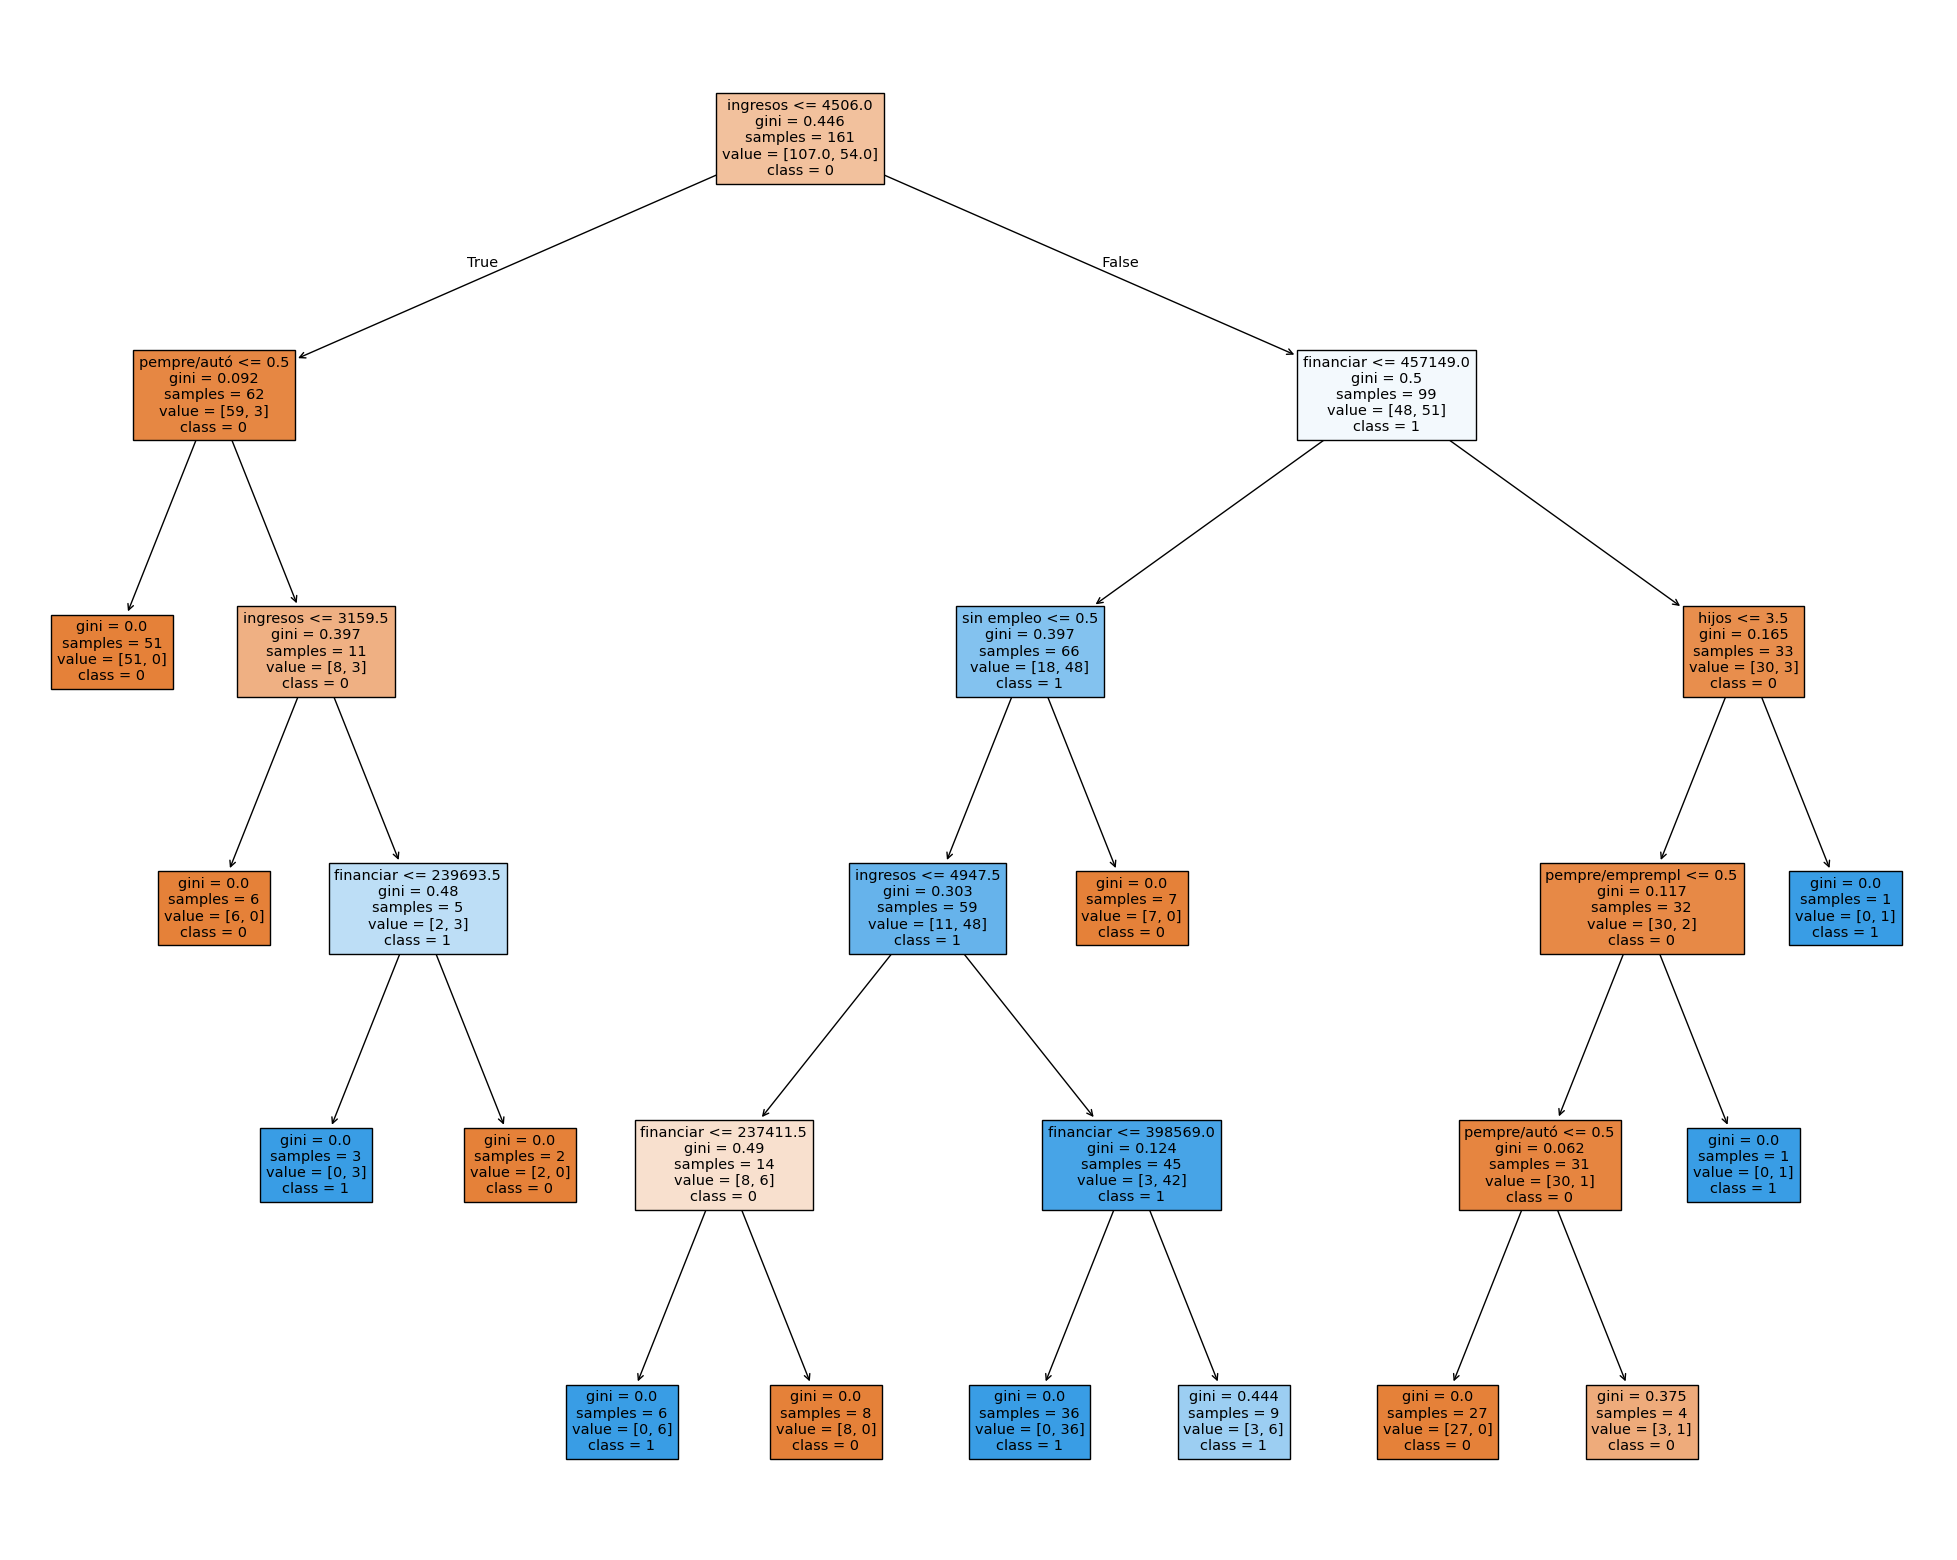

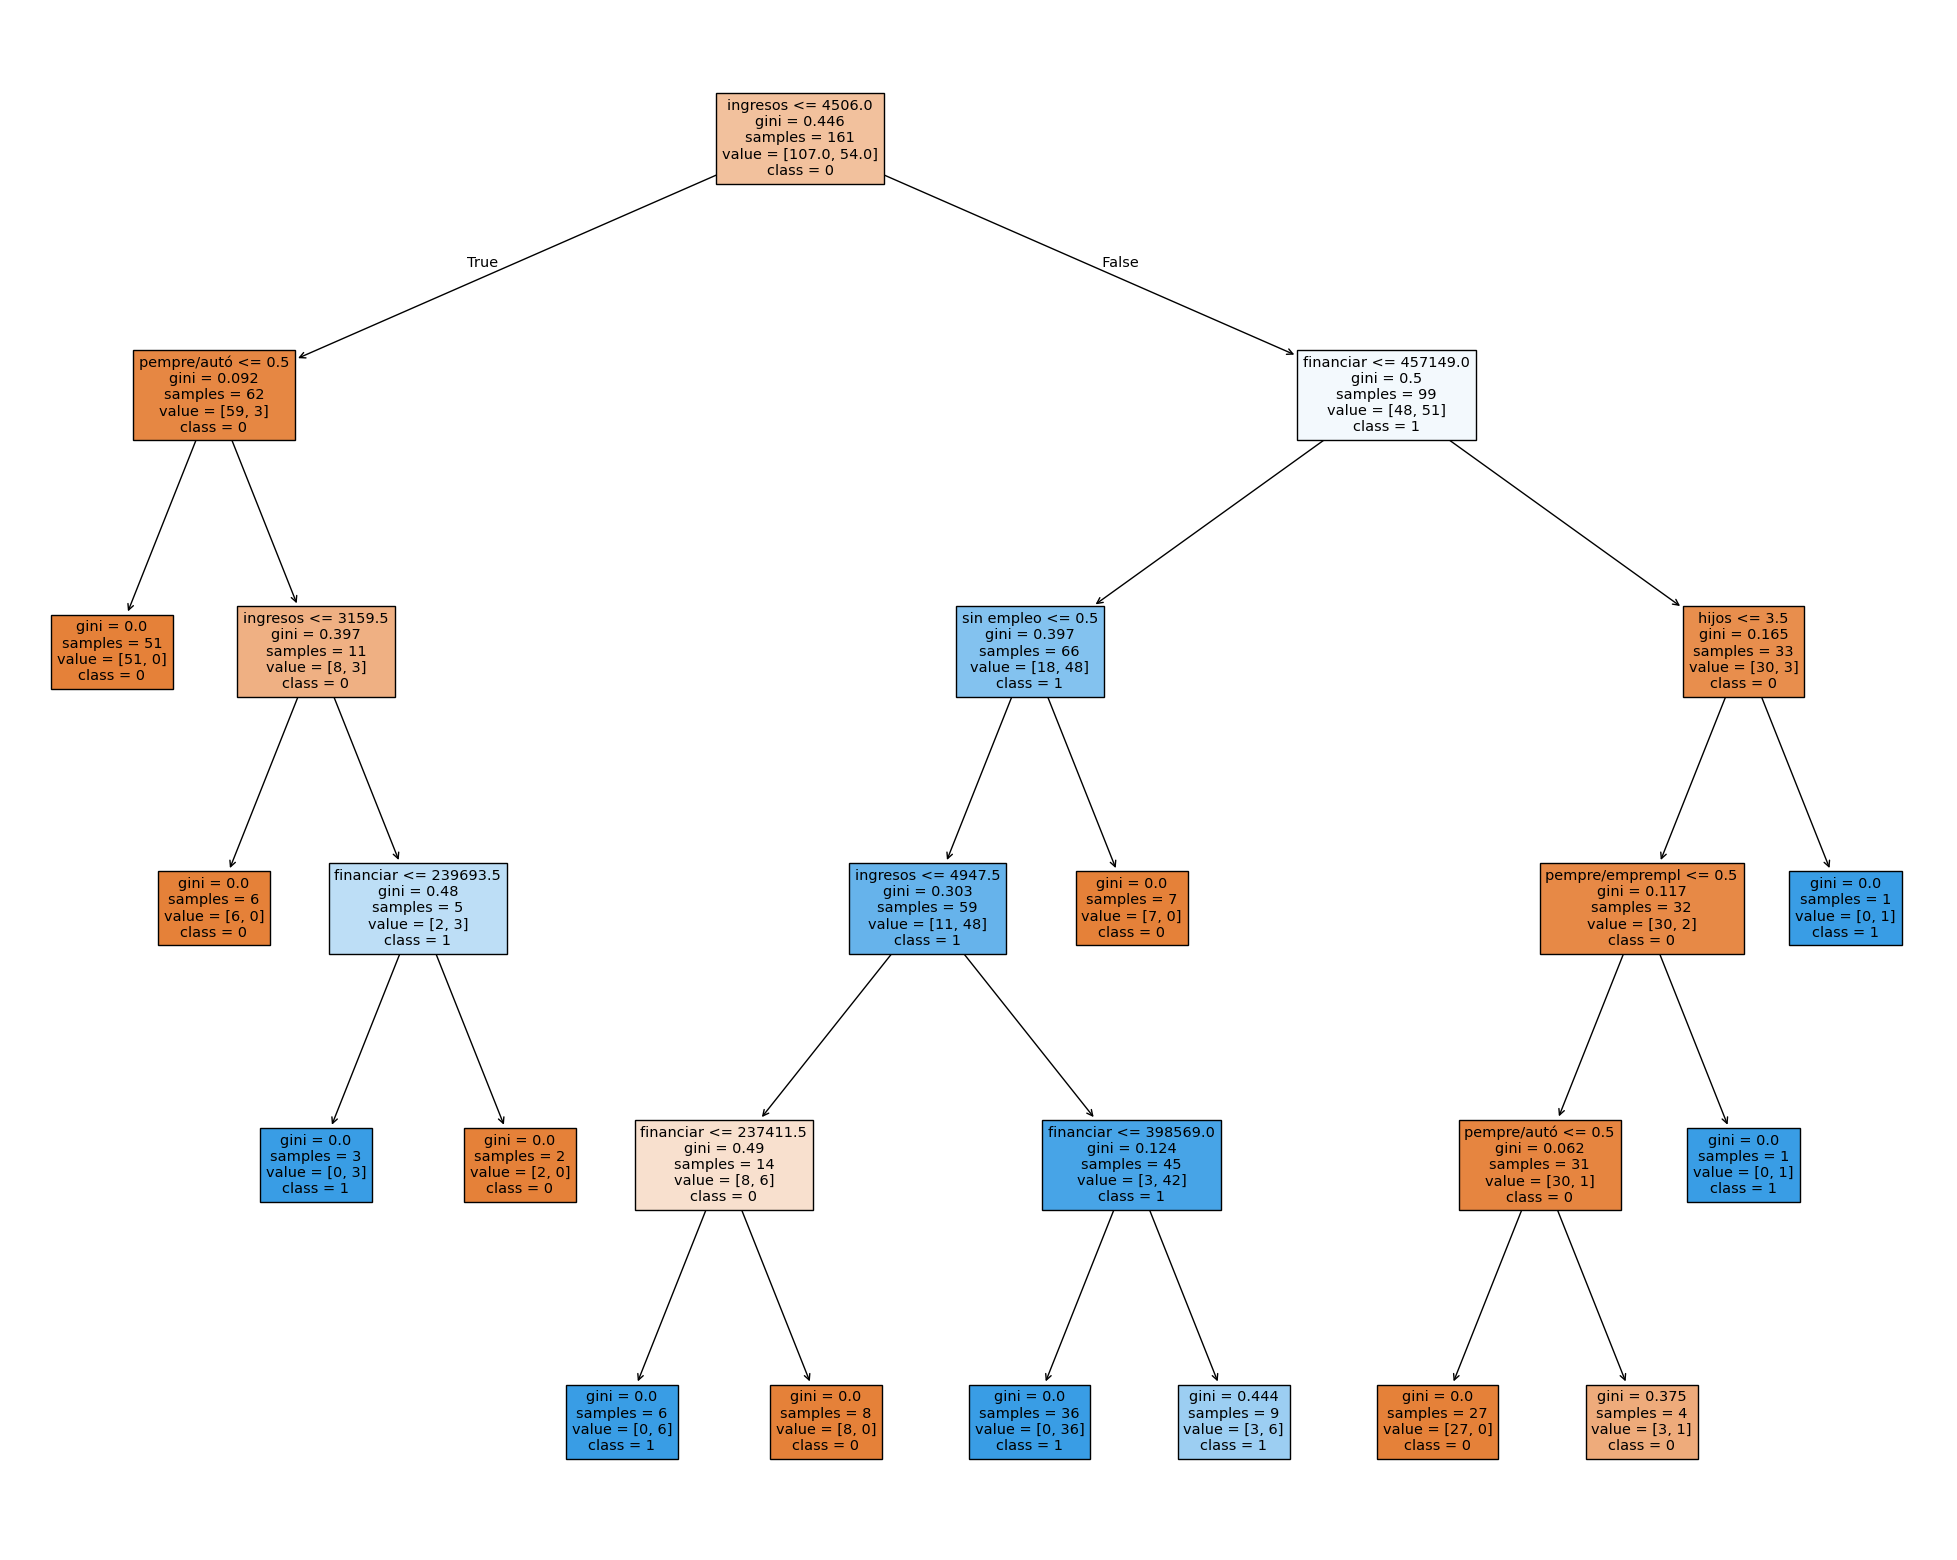

In [156]:
fn=["ingresos","gastos","financiar","hijos","soltero","casado","divorciado","sin empleo","autónomo","empleado",
     "pautó","pempl","pautó/asala","pempre/autó",
      "pempre/emprempl"]
cn=["0","1"]
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clt, 
                   feature_names=fn,  
                   class_names=cn,
                   filled=True)
plt.show()

In [157]:
tuned_parameters = [{'max_depth': [8,9,10,11,12],
                     'n_estimators': [50,100,200]}]

gs = GridSearchCV(
    RandomForestClassifier(),
    tuned_parameters,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [158]:
print("El mejor párametro es:",gs_results.best_params_)

El mejor párametro es: {'max_depth': 11, 'n_estimators': 200}


In [159]:
rf = RandomForestClassifier(n_estimators = 200, max_depth = 12)
rf.fit(X_train, y_train);

In [160]:
y_pred = rf.predict(X_test)

In [161]:
# evaluamos modelo
print('Accuracy del Tree Classifier en training set: {:.2f}'.format(rf.score(X_train, y_train)))
print('Accuracy del Tree Classifier en test set: {:.2f}'.format(rf.score(X_test, y_test)))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
      
print("Classification report:")
print(classification_report(y_test, y_pred))

Accuracy del Tree Classifier en training set: 1.00
Accuracy del Tree Classifier en test set: 0.88
Confusion matrix:
[[27  1]
 [ 4  9]]
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.92        28
           1       0.90      0.69      0.78        13

    accuracy                           0.88        41
   macro avg       0.89      0.83      0.85        41
weighted avg       0.88      0.88      0.87        41



In [162]:
z = X_train.columns
y=rf.feature_importances_
print(pd.DataFrame(y, z))

                                                        0
ingresos                                         0.357439
gastos                                           0.120402
financiar                                        0.222988
hijos                                            0.103665
soltero                                          0.030503
casado                                           0.018989
divorciado                                       0.017888
sin empleo                                       0.031385
autónomo                                         0.010538
empleado                                         0.009278
pareja: autónomos                                0.010828
pareja: empleados                                0.021378
pareja: autónomo y asalariado                    0.012844
pareja: empresario y autónomo                    0.016620
pareja: dos empresarios / empresario y empleado  0.015257


### Prediction of new cases

In [164]:
casos = {'ingresos': [2000,6000,9000], 'gastos': [500,3400,2250], 'financiar': [200000,320000,39000],
        'hijos': [0,2,1], 'soltero': [0,0,1], 'casado': [1,1,0], 'divorciado': [0,0,0], 'sin empleo': [0,0,0],
        'autónomo': [0,0,1], 'empleado': [0,0,0], 'pareja: autónomos': [0,0,0], 'pareja: empleados': [0,0,0],
        'pareja: autónomo y asalariado': [0,1,0], 'pareja: empresario y autónomo': [0,0,0], 
        'pareja: dos empresarios / empresario y empleado': [1,0,0]}

casos = pd.DataFrame(casos)
casos

,ingresos,gastos,financiar,hijos,soltero,casado,divorciado,sin empleo,autónomo,empleado,pareja: autónomos,pareja: empleados,pareja: autónomo y asalariado,pareja: empresario y autónomo,pareja: dos empresarios / empresario y empleado
0,2000,500,200000,0,0,1,0,0,0,0,0,0,0,0,1
1,6000,3400,320000,2,0,1,0,0,0,0,0,0,1,0,0
2,9000,2250,39000,1,1,0,0,0,1,0,0,0,0,0,0


In [165]:
y_pred = rf.predict(casos)
y_pred

array([0, 1, 1], dtype=int64)